In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from keras.models import Sequential, load_model, Model,Input
from keras.layers import Dense,GlobalAvgPool2D, Conv2D, MaxPool2D,AvgPool2D, GlobalAveragePooling2D,AveragePooling2D ,Softmax, BatchNormalization, ReLU, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import concatenate,Concatenate
import matplotlib.pyplot as plt
from matplotlib.image import imread 
%matplotlib inline
import pandas as pd
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,accuracy_score


# import cv

#aug_major_minor 
train data = 896-896
max no of images in normal=all raw+ all augmented

In [ ]:
train_data_generation = ImageDataGenerator(rescale=1./255)
training_set = train_data_generation.flow_from_directory('/content/drive/MyDrive/gp/50:50/AUG_MAJOR-MINOR/train',
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode='binary',seed=0)

# preprocessing the testing set
test_data_generation = ImageDataGenerator(rescale=1./255)
testing_set = test_data_generation.flow_from_directory('/content/drive/MyDrive/gp/50:50/AUG_MAJOR-MINOR/test',
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       class_mode='binary',seed=0)

val_data_generation = ImageDataGenerator(rescale=1./255)
val_set = test_data_generation.flow_from_directory('/content/drive/MyDrive/gp/50:50/AUG_MAJOR-MINOR/val',
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       class_mode='binary',seed=0)



Found 1792 images belonging to 2 classes.
Found 170 images belonging to 2 classes.
Found 523 images belonging to 2 classes.


In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score

true_labels = np.concatenate([testing_set.next()[1] for i in range(testing_set.__len__())])
true_labels

array([1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.,
       0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1.,
       1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
from sklearn.metrics import classification_report

label_names =['abnormal','normal']

In [ ]:
def densenet(img_shape, n_class,f=32):
  repetitions = [6, 12, 24, 16]
  
  def bn_rl_conv(model, f, k=1, s=1, p='same'):
    model = BatchNormalization()(model)
    model = ReLU()(model)
    model = Conv2D(f, k, strides=s, padding=p)(model)
    return model
  
  
  def dense_block(conc, r):
    for i in range(r):
      model = bn_rl_conv(conc, 4*f)
      model = bn_rl_conv(model, f, 3)
      conc = Concatenate()([conc, model])
    return conc
  
  
  def transition_block(model):
    model = bn_rl_conv(model, K.int_shape(model)[-1] // 2)
    model = AvgPool2D(2, strides=2, padding='same')(model)
    return model
  
  
  input = Input(img_shape)
  
  model = Conv2D(64, 7, strides=2, padding='same')(input)
  model = MaxPool2D(3, strides=2, padding='same')(model)
  
  for r in repetitions:
    d = dense_block(model, r)
    model = transition_block(d)
  
  model = GlobalAvgPool2D()(d)
  
  output = Dense(n_class, activation='sigmoid')(model)
  
  model = Model(input, output)
  return model



In [ ]:
_model_major_minor= densenet([224,224,3],2)
_model_major_minor.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_s=EarlyStopping(monitor='val_accuracy',patience=15,mode='max',restore_best_weights=True)

_model_major_minor.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history_major_minor=_model_major_minor.fit(x=training_set, validation_data=val_set, epochs=150,callbacks=([early_s]))

Epoch 1/150
56/56 [==============================] - 402s 7s/step - loss: 0.8199 - accuracy: 0.6864 - val_loss: 0.9567 - val_accuracy: 0.4742
Epoch 2/150
56/56 [==============================] - 46s 826ms/step - loss: 0.6274 - accuracy: 0.7087 - val_loss: 0.6717 - val_accuracy: 0.6004
Epoch 3/150
56/56 [==============================] - 46s 821ms/step - loss: 0.6111 - accuracy: 0.7427 - val_loss: 0.7365 - val_accuracy: 0.6654
Epoch 4/150
56/56 [==============================] - 47s 836ms/step - loss: 0.5003 - accuracy: 0.7662 - val_loss: 0.8361 - val_accuracy: 0.4283
Epoch 5/150
56/56 [==============================] - 46s 816ms/step - loss: 0.5361 - accuracy: 0.7712 - val_loss: 0.8238 - val_accuracy: 0.4876
Epoch 6/150
56/56 [==============================] - 46s 819ms/step - loss: 0.4770 - accuracy: 0.7807 - val_loss: 0.6279 - val_accuracy: 0.6329
Epoch 7/150
56/56 [==============================] - 46s 814ms/step - loss: 0.4623 - accuracy: 0.7879 - val_loss: 0.6972 - val_accuracy: 0

In [ ]:
_model_major_minor.save('/content/drive/MyDrive/gp/Major_Minor.h5')


In [ ]:
prediction=_model_major_minor.predict(testing_set)
classes_x=np.argmax(prediction,axis=1)
classes_x

array([1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
cf = confusion_matrix(y_true= true_labels, y_pred= classes_x)
score = accuracy_score(y_true= true_labels, y_pred=classes_x)
print(cf)
print('the model performane is: ', score*100, "%")

[[94 11]
 [ 9 56]]
the model performane is:  88.23529411764706 %


In [ ]:
print(classification_report(true_labels, classes_x,target_names=label_names))

              precision    recall  f1-score   support

    abnormal       0.91      0.90      0.90       105
      normal       0.84      0.86      0.85        65

    accuracy                           0.88       170
   macro avg       0.87      0.88      0.88       170
weighted avg       0.88      0.88      0.88       170



In [ ]:
_model_major_minor.fit(x=training_set, validation_data=val_set, epochs=150,callbacks=([early_s]))

Epoch 1/150
56/56 [==============================] - 46s 822ms/step - loss: 0.2721 - accuracy: 0.8934 - val_loss: 12.5908 - val_accuracy: 0.7228
Epoch 2/150
56/56 [==============================] - 46s 815ms/step - loss: 0.3636 - accuracy: 0.8549 - val_loss: 5.5273 - val_accuracy: 0.6444
Epoch 3/150
56/56 [==============================] - 47s 842ms/step - loss: 0.3137 - accuracy: 0.8750 - val_loss: 1.1546 - val_accuracy: 0.6635
Epoch 4/150
56/56 [==============================] - 46s 827ms/step - loss: 0.3272 - accuracy: 0.8666 - val_loss: 0.4167 - val_accuracy: 0.8222
Epoch 5/150
56/56 [==============================] - 46s 828ms/step - loss: 0.3143 - accuracy: 0.8717 - val_loss: 0.4333 - val_accuracy: 0.8164
Epoch 6/150
56/56 [==============================] - 47s 832ms/step - loss: 0.3032 - accuracy: 0.8772 - val_loss: 0.3479 - val_accuracy: 0.8585
Epoch 7/150
56/56 [==============================] - 46s 817ms/step - loss: 0.2545 - accuracy: 0.8984 - val_loss: 0.4358 - val_accuracy

In [ ]:
_model_major_minor.save('/content/drive/MyDrive/gp/Major_Minor_retrain.h5')


In [ ]:
prediction=_model_major_minor.predict(testing_set)
classes_x=np.argmax(prediction,axis=1)

classes_x

array([0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0])

In [ ]:
cf = confusion_matrix(y_true= true_labels, y_pred= classes_x)
score = accuracy_score(y_true= true_labels, y_pred=classes_x)
print(cf)
print('the model performane is: ', score*100, "%")

[[64 41]
 [39 26]]
the model performane is:  52.94117647058824 %


In [ ]:
print(classification_report(true_labels, classes_x,target_names=label_names))

              precision    recall  f1-score   support

    abnormal       0.62      0.61      0.62       105
      normal       0.39      0.40      0.39        65

    accuracy                           0.53       170
   macro avg       0.50      0.50      0.50       170
weighted avg       0.53      0.53      0.53       170



#minor_minor
448-448\
max no of raw data

In [ ]:
train_data_generation = ImageDataGenerator(rescale=1./255)
training_set = train_data_generation.flow_from_directory('/content/drive/MyDrive/gp/50:50/MINOR-MINOR/train',
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode='binary',seed=0)



val_data_generation = ImageDataGenerator(rescale=1./255)
val_set = test_data_generation.flow_from_directory('/content/drive/MyDrive/gp/50:50/MINOR-MINOR/val',
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       class_mode='binary',seed=0)


Found 896 images belonging to 2 classes.
Found 503 images belonging to 2 classes.


In [ ]:
true_labels=[]
true_labels = np.concatenate([testing_set.next()[1] for i in range(testing_set.__len__())])
true_labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 1.

In [ ]:
_model_minor_minor= densenet([224,224,3],2)
# _model_minor_minor.summary()

In [ ]:
_model_minor_minor.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history_minor_minor=_model_minor_minor.fit(x=training_set, validation_data=val_set, epochs=150,callbacks=([early_s]))

Epoch 1/150
28/28 [==============================] - 258s 9s/step - loss: 1.0676 - accuracy: 0.7065 - val_loss: 37.9752 - val_accuracy: 0.3936
Epoch 2/150
28/28 [==============================] - 25s 884ms/step - loss: 0.4705 - accuracy: 0.7991 - val_loss: 2.7190 - val_accuracy: 0.3817
Epoch 3/150
28/28 [==============================] - 25s 883ms/step - loss: 0.4713 - accuracy: 0.7757 - val_loss: 1.4495 - val_accuracy: 0.3817
Epoch 4/150
28/28 [==============================] - 25s 882ms/step - loss: 0.4694 - accuracy: 0.7511 - val_loss: 1.0294 - val_accuracy: 0.3817
Epoch 5/150
28/28 [==============================] - 25s 880ms/step - loss: 0.4438 - accuracy: 0.8002 - val_loss: 0.9154 - val_accuracy: 0.3817
Epoch 6/150
28/28 [==============================] - 25s 878ms/step - loss: 0.4374 - accuracy: 0.8147 - val_loss: 1.3726 - val_accuracy: 0.3817
Epoch 7/150
28/28 [==============================] - 25s 880ms/step - loss: 0.3989 - accuracy: 0.8237 - val_loss: 1.5172 - val_accuracy: 

In [ ]:
_model_minor_minor.save('/content/drive/MyDrive/gp/Minor_Minor.h5')


In [ ]:
prediction=_model_minor_minor.predict(testing_set)
classes_x=np.argmax(prediction,axis=1)
classes_x

array([0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1])

In [ ]:
cf = confusion_matrix(y_true= true_labels, y_pred= classes_x)
score = accuracy_score(y_true= true_labels, y_pred=classes_x)
print(cf)
print('the model performane is: ', score*100, "%")

[[96  9]
 [12 53]]
the model performane is:  87.6470588235294 %


In [ ]:
print(classification_report(true_labels, classes_x,target_names=label_names))

              precision    recall  f1-score   support

    abnormal       0.89      0.91      0.90       105
      normal       0.85      0.82      0.83        65

    accuracy                           0.88       170
   macro avg       0.87      0.86      0.87       170
weighted avg       0.88      0.88      0.88       170



In [ ]:
print(classification_report(true_labels, classes_x,target_names=label_names))

              precision    recall  f1-score   support

    abnormal       0.97      0.88      0.92       393
      normal       0.52      0.82      0.64        65

    accuracy                           0.87       458
   macro avg       0.75      0.85      0.78       458
weighted avg       0.90      0.87      0.88       458



# major-major
726-726\
max no of row abnormal data

In [ ]:
train_data_generation = ImageDataGenerator(rescale=1./255)
training_set = train_data_generation.flow_from_directory('/content/drive/MyDrive/gp/50:50/MAJOR-MAJOR/train',
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode='binary',seed=0)

# preprocessing the testing set
test_data_generation = ImageDataGenerator(rescale=1./255)
testing_set = test_data_generation.flow_from_directory('/content/drive/MyDrive/gp/50:50/MAJOR-MAJOR/test',
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       class_mode='binary',seed=0)

val_data_generation = ImageDataGenerator(rescale=1./255)
val_set = test_data_generation.flow_from_directory('/content/drive/MyDrive/gp/50:50/MAJOR-MAJOR/val',
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       class_mode='binary',seed=0)


Found 1452 images belonging to 2 classes.
Found 170 images belonging to 2 classes.
Found 503 images belonging to 2 classes.


In [ ]:
true_labels=[]
true_labels = np.concatenate([testing_set.next()[1] for i in range(testing_set.__len__())])
true_labels

array([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1.,
       0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1.,
       1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1.],
      dtype=float32)

In [ ]:
_model_major_major= densenet([224,224,3],2)

_model_major_major.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history_major_major=_model_major_major.fit(x=training_set, validation_data=val_set, epochs=150,callbacks=([early_s]))

Epoch 1/150
46/46 [==============================] - 63s 895ms/step - loss: 1.0009 - accuracy: 0.6405 - val_loss: 57.5779 - val_accuracy: 0.4831
Epoch 2/150
46/46 [==============================] - 38s 817ms/step - loss: 0.5717 - accuracy: 0.7300 - val_loss: 17.0171 - val_accuracy: 0.3817
Epoch 3/150
46/46 [==============================] - 38s 816ms/step - loss: 0.5883 - accuracy: 0.7273 - val_loss: 28.9122 - val_accuracy: 0.3917
Epoch 4/150
46/46 [==============================] - 38s 820ms/step - loss: 0.6183 - accuracy: 0.7211 - val_loss: 83.6447 - val_accuracy: 0.5189
Epoch 5/150
46/46 [==============================] - 38s 820ms/step - loss: 0.5643 - accuracy: 0.7541 - val_loss: 9.4629 - val_accuracy: 0.6083
Epoch 6/150
46/46 [==============================] - 38s 821ms/step - loss: 0.5713 - accuracy: 0.7459 - val_loss: 2.3617 - val_accuracy: 0.6123
Epoch 7/150
46/46 [==============================] - 37s 813ms/step - loss: 0.4920 - accuracy: 0.7734 - val_loss: 0.7460 - val_accur

In [ ]:
_model_major_major.save('/content/drive/MyDrive/gp/Major_Major.h5')


In [ ]:
_model_major_major.save('/content/drive/MyDrive/gp/Major_Major2.h5')


In [ ]:
prediction=_model_major_major.predict(testing_set)
classes_x=np.argmax(prediction,axis=1)
classes_x

array([0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0])

In [ ]:
cf = confusion_matrix(y_true= true_labels, y_pred= classes_x)
score = accuracy_score(y_true= true_labels, y_pred=classes_x)
print(cf)
print('the model performane is: ', score*100, "%")

[[57 48]
 [45 20]]
the model performane is:  45.294117647058826 %


In [ ]:
print(classification_report(true_labels, classes_x,target_names=label_names))

              precision    recall  f1-score   support

    abnormal       0.56      0.54      0.55       105
      normal       0.29      0.31      0.30        65

    accuracy                           0.45       170
   macro avg       0.43      0.43      0.43       170
weighted avg       0.46      0.45      0.46       170



#pretrained

In [ ]:
# preprocessing the training set
train_data_generation = ImageDataGenerator(rescale=1./255)
training_set = train_data_generation.flow_from_directory('/content/drive/MyDrive/gp/Splitted/train',
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode='binary',seed=0)

# preprocessing the valid set
valid_data_generation = ImageDataGenerator(rescale=1./255)
validing_set = valid_data_generation.flow_from_directory('/content/drive/MyDrive/gp/Splitted/val',
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       class_mode='binary',seed=0)

Found 1174 images belonging to 2 classes.
Found 503 images belonging to 2 classes.


In [ ]:
test_data_generation = ImageDataGenerator(rescale=1./255)
testing_set = test_data_generation.flow_from_directory('/content/drive/MyDrive/gp/Splitted/test',
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       class_mode='binary',seed=0)

Found 170 images belonging to 2 classes.


In [ ]:
batch_size =32
X_test, y_test = next(testing_set)
for i in range(int(len(testing_set)/batch_size)-1): #1st batch is already fetched before the for loop.
    img , label = next(testing_set)
    X_test = np.append(X_test, img, axis=0 )
    y_test = np.append(y_test, label, axis=0)

print(X_test.shape, y_test.shape)

(32, 224, 224, 3) (32,)


1.0


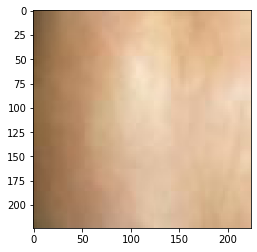

In [ ]:
from matplotlib.image import imread
print(y_test[2])
plt.imshow(X_test[2])

In [ ]:
from sklearn.metrics import classification_report

label_names =['abnormal','normal']

In [ ]:
true_labels = np.concatenate([testing_set.next()[1] for i in range(testing_set.__len__())])
true_labels

array([0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1.,
       1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1.],
      dtype=float32)

# keras with last layer replaced

In [ ]:
model=tf.keras.applications.DenseNet121(include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling='max',
    classes=2)
base_inputs = model.layers[0].input
base_output = model.layers[-2].output
output = layers.Dense(2,activation='sigmoid')(base_output)
model = keras.Model(base_inputs, output)
print("densenet",model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_s=EarlyStopping(monitor='val_accuracy',patience=10,mode='max',restore_best_weights=True)

In [ ]:
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.fit(x=training_set, validation_data=validing_set, epochs=150,callbacks=([early_s]))

Epoch 1/150
37/37 [==============================] - 408s 10s/step - loss: 0.5615 - accuracy: 0.7308 - val_loss: 3.3031 - val_accuracy: 0.3897
Epoch 2/150
37/37 [==============================] - 30s 818ms/step - loss: 0.4335 - accuracy: 0.7947 - val_loss: 1.3005 - val_accuracy: 0.3757
Epoch 3/150
37/37 [==============================] - 30s 819ms/step - loss: 0.3952 - accuracy: 0.8373 - val_loss: 1.4355 - val_accuracy: 0.3817
Epoch 4/150
37/37 [==============================] - 30s 822ms/step - loss: 0.3868 - accuracy: 0.8237 - val_loss: 1.0712 - val_accuracy: 0.4851
Epoch 5/150
37/37 [==============================] - 30s 818ms/step - loss: 0.3748 - accuracy: 0.8365 - val_loss: 1.9943 - val_accuracy: 0.4294
Epoch 6/150
37/37 [==============================] - 30s 816ms/step - loss: 0.3353 - accuracy: 0.8671 - val_loss: 2.0727 - val_accuracy: 0.4095
Epoch 7/150
37/37 [==============================] - 30s 822ms/step - loss: 0.3298 - accuracy: 0.8646 - val_loss: 1.2533 - val_accuracy: 

In [ ]:
prediction=model.predict(testing_set)
classes_x=np.argmax(prediction,axis=1)
classes_x

array([0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
cf = confusion_matrix(y_true= true_labels, y_pred= classes_x)
score = accuracy_score(y_true= true_labels, y_pred=classes_x)
print(cf)
print('the model performane is: ', score*100, "%")

[[71 35]
 [41 23]]
the model performane is:  55.294117647058826 %


In [ ]:
print(classification_report(true_labels, classes_x,target_names=label_names))

              precision    recall  f1-score   support

    abnormal       0.63      0.67      0.65       106
      normal       0.40      0.36      0.38        64

    accuracy                           0.55       170
   macro avg       0.52      0.51      0.51       170
weighted avg       0.54      0.55      0.55       170



In [ ]:
cf = confusion_matrix(y_true= true_labels, y_pred= classes_x)
score = accuracy_score(y_true= true_labels, y_pred=classes_x)
print(cf)
print('the model performane is: ', score*100, "%")

[[76 29]
 [39 26]]
the model performane is:  60.0 %


In [ ]:
print(classification_report(true_labels, classes_x,target_names=label_names))

              precision    recall  f1-score   support

    abnormal       0.66      0.72      0.69       105
      normal       0.47      0.40      0.43        65

    accuracy                           0.60       170
   macro avg       0.57      0.56      0.56       170
weighted avg       0.59      0.60      0.59       170



# keras densenet121

In [ ]:
model1=tf.keras.applications.DenseNet121(include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling='avg',
    classes=2)
# base_inputs = model1.layers[0].input
# base_output = model1.layers[-2].output
# output = layers.Dense(2,activation='sigmoid')(base_output)
# model1 = keras.Model(base_inputs, output)
# print("densenet",model1.summary())

In [ ]:
prediction1=model1.predict(testing_set)
classes_x1=np.argmax(prediction1,axis=1)
classes_x1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
cf1 = confusion_matrix(y_true= true_labels, y_pred= classes_x1)
score1 = accuracy_score(y_true= true_labels, y_pred=classes_x1)
print(cf1)
print('the model performane is: ', score1*100, "%")

[[106   0]
 [ 64   0]]
the model performane is:  62.35294117647059 %


In [ ]:
print(classification_report(true_labels, classes_x1,target_names=label_names))

              precision    recall  f1-score   support

    abnormal       0.00      0.00      0.00       106
      normal       0.38      1.00      0.55        64

    accuracy                           0.38       170
   macro avg       0.19      0.50      0.27       170
weighted avg       0.14      0.38      0.21       170



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#effecientnet

In [ ]:
model_e0=tf.keras.applications.EfficientNetB0(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(224,224,3),
    pooling='avg',
    classes=2,
    classifier_activation="sigmoid"

)
# base_inputs_e0 = model_e0.layers[0].input
# base_output_e0 = model_e0.layers[-2].output
# output_e0 = layers.Dense(2, activation='softmax')(base_output_e0)
# model_e0 = keras.Model(base_inputs_e0, output_e0)
print("effecient",model_e0.summary())

In [ ]:
model_e0.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model_e0.fit(x=training_set, validation_data=validing_set, epochs=150,callbacks=([early_s]))

Epoch 1/150
37/37 [==============================] - 34s 650ms/step - loss: 0.5014 - accuracy: 0.7896 - val_loss: 4.2348 - val_accuracy: 0.3817
Epoch 2/150
37/37 [==============================] - 22s 603ms/step - loss: 0.4288 - accuracy: 0.8203 - val_loss: 3.7268 - val_accuracy: 0.3817
Epoch 3/150
37/37 [==============================] - 22s 603ms/step - loss: 0.3877 - accuracy: 0.8416 - val_loss: 4.2903 - val_accuracy: 0.3817
Epoch 4/150
37/37 [==============================] - 22s 600ms/step - loss: 0.3771 - accuracy: 0.8501 - val_loss: 4.3136 - val_accuracy: 0.3817
Epoch 5/150
37/37 [==============================] - 22s 599ms/step - loss: 0.3582 - accuracy: 0.8688 - val_loss: 4.4634 - val_accuracy: 0.3817
Epoch 6/150
37/37 [==============================] - 22s 600ms/step - loss: 0.2940 - accuracy: 0.8867 - val_loss: 4.4282 - val_accuracy: 0.3817
Epoch 7/150
37/37 [==============================] - 22s 599ms/step - loss: 0.2452 - accuracy: 0.9114 - val_loss: 4.6153 - val_accuracy:

KeyboardInterrupt: ignored

In [ ]:
prediction_e0=model_e0.predict(testing_set)
classes=np.argmax(prediction_e0,axis=1)
classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
cf_e0 = confusion_matrix(y_true= true_labels, y_pred= classes)
score_e0 = accuracy_score(y_true= true_labels, y_pred=classes)
print(cf_e0)
print('the efficient performane is: ', score_e0*100, "%")

[[106   0]
 [ 64   0]]
the efficient performane is:  62.35294117647059 %


In [ ]:
print(classification_report(true_labels, classes,target_names=label_names))

              precision    recall  f1-score   support

    abnormal       0.62      1.00      0.77       106
      normal       0.00      0.00      0.00        64

    accuracy                           0.62       170
   macro avg       0.31      0.50      0.38       170
weighted avg       0.39      0.62      0.48       170



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
